# Logging Custom Images

Run this notebook on Google Colab:

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AG-Peter/encodermap/blob/main/tutorials/notebooks_customization/writing_custom_images_to_tensorboard.ipynb)

Find the documentation of EncoderMap:

https://ag-peter.github.io/encodermap

### For Google colab only:

If you're on Google colab, please uncomment these lines and install EncoderMap.

In [1]:
# !wget https://raw.githubusercontent.com/AG-Peter/encodermap/main/tutorials/install_encodermap_google_colab.sh
# !sudo bash install_encodermap_google_colab.sh

## Primer


In this tutorial we will learn how to write custom images to Tensorboard. This can be done in two ways:

- Providing `encodermap.EncoderMap.add_images_to_tensorboard` with addtional functions that return a stringIO buffer object and use the latent space of the Autoencoder.
- Writing custom callbacks and adding them to EncoderMap.

As usual, we will start to import some packages. Along the usual packages we import the built-in package `io`.

In [2]:
import numpy as np
import encodermap as em
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import pandas as pd

import io

%matplotlib inline

2023-02-06 10:08:34.768688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 10:08:34.904708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-06 10:08:34.904731: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-02-06 10:08:35.641834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-06 10:08:35.641913: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-06 10:08:35.641921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


We will use `io` to write a png-file to a buffer (not to disk) and provide that puffer to Tensorboard for visualization. But first, let us think about what to plot.

## Logging via a custom function.

**Idea:** Plot the inverted-log density of the low-dimensional/bottleneck/latent-space which correlates to the system's free energy surface (not quite, but let's assume it does).

First let's start plotting such a graph in pure matploltib. As example data we will use a 2D Gaussian. We know what to expect from a hypothetical free energy landscape of such a point distribution. Low free energies in the middle, where the density is high and high free energies at the fringes, where the points are less dense.

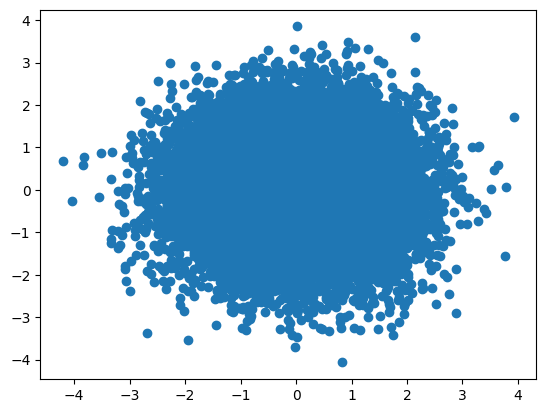

In [3]:
xy_data = np.vstack([np.random.normal(size=20000), np.random.normal(size=20000)]).T
plt.close('all')
plt.scatter(*xy_data.T)

### Matplotlib implementation

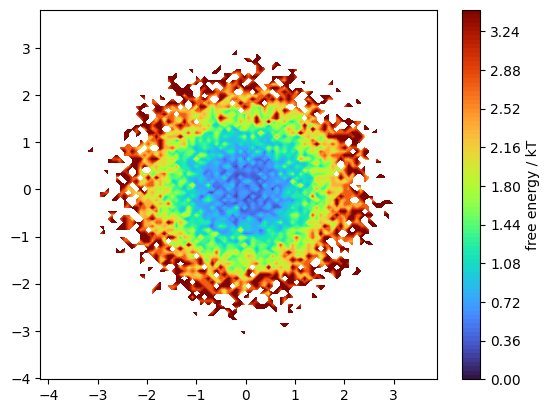

In [4]:
def to_free_energy(xy, bins=100):
    """Adapted from pyemma.plots.plot_free_energy()"""
    
    # create histogram
    H, xedges, yedges = np.histogram2d(*xy.T, bins=bins)
    x = 0.5 * (xedges[:-1] + xedges[1:])
    y = 0.5 * (yedges[:-1] + yedges[1:])
    
    # to density
    density = H / float(H.sum())
    
    # to free energy
    F = np.inf * np.ones(shape=H.shape)
    nonzero = density.nonzero()
    F[nonzero] = - np.log(density[nonzero])
    # shift so no zeros happen
    F[nonzero] -= np.min(F[nonzero])
    return x, y, F

plt.close('all')
    
fig, ax = plt.subplots()

mappable = plt.contourf(*to_free_energy(xy_data), cmap='turbo', levels=100)
cax = fig.colorbar(mappable, ax=ax)
cax.set_label("free energy / kT")

### Provide this function to EncoderMap

We need to make some adjustments to be able to see similar images in tensorboard. First: Everything needs to be contained in a single function, that takes the low-dimensional output of the encoder as input. Second: The function needs to return a tensorflow image.

Some other lines we have to add:
- `matplotlib.use('Agg')`. Overwrites the current matplotlib backend. So the images created during training are not rendered in the notebook.
- buf = io.BytesIO(). Raw bytecode buffer. These are the actual bytes that would have ended up on your disk, if you would have written the png to it.

In [5]:
def free_energy_tensorboard(lowd):
    plt.close('all')
    matplotlib.use('Agg')  # overwrites current backend of notebook
    
    # calculate free energy
    H, xedges, yedges = np.histogram2d(*lowd.T, bins=50)
    x = 0.5 * (xedges[:-1] + xedges[1:])
    y = 0.5 * (yedges[:-1] + yedges[1:])
    
    # to density
    density = H / float(H.sum())
    
    # to free energy
    F = np.inf * np.ones(shape=H.shape)
    nonzero = density.nonzero()
    F[nonzero] = - np.log(density[nonzero])
    # shift so no zeros happen
    F[nonzero] -= np.min(F[nonzero])
    
    # actual plotting
    fig, ax = plt.subplots()
    mappable = plt.contourf(x, y, F, cmap='turbo', levels=100)
    cax = fig.colorbar(mappable, ax=ax)
    cax.set_label("free energy / kT")
    
    # BytesIO
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    # tensorflow
    image = tf.image.decode_png(buf.getvalue(), 4) # 4 is due to RGBA colors.
    image = tf.expand_dims(image, 0)
    return image

This function will return a tf.Tensor, that we can now log in tensorboard.

In [6]:
free_energy_tensorboard(xy_data)

2023-02-06 10:08:39.422044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-06 10:08:39.422094: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 10:08:39.422119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az175-660): /proc/driver/nvidia/version does not exist
2023-02-06 10:08:39.422478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(1, 480, 640, 4), dtype=uint8, numpy=
array([[[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        ...,

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 

### Train EncoderMap with our new function.

First get the input data

In [7]:
df = pd.read_csv('asp7.csv')
dihedrals = df.iloc[:,:-1].values.astype(np.float32)
cluster_ids = df.iloc[:,-1].values
print(dihedrals.shape, cluster_ids.shape)
print(df.shape)

(10001, 12) (10001,)
(10001, 13)


Cerate the parameters.

In [8]:
parameters = em.Parameters(
tensorboard=True,
periodicity=2*np.pi,
n_steps=100,
main_path=em.misc.run_path('runs/custom_images')
)

When calling the method `add_images_to_tensorboard()` we can provide a list of additional functions. That way we can add as much custom functions as we like. In this case, we only add the new `free_energy_tensorboard` function.

In [9]:
e_map = em.EncoderMap(parameters, dihedrals)
e_map.add_images_to_tensorboard(dihedrals, image_step=1, additional_fns=[free_energy_tensorboard])

Output files are saved to runs/custom_images/run0 as defined in 'main_path' in the parameters.


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Saved a text-summary of the model and an image in runs/custom_images/run0, as specified in 'main_path' in the parameters.
Logging images with (10001, 12)-shaped data every 1 epochs to Tensorboard at runs/custom_images/run0


In [10]:
e_map.train()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s, Loss after step ?=?]

  1%|          | 1/100 [00:06<11:13,  6.80s/it, Loss after step ?=?]

  2%|▏         | 2/100 [00:07<05:14,  3.21s/it, Loss after step ?=?]

  3%|▎         | 3/100 [00:08<03:29,  2.16s/it, Loss after step ?=?]

  4%|▍         | 4/100 [00:09<02:31,  1.58s/it, Loss after step ?=?]

  5%|▌         | 5/100 [00:09<02:00,  1.27s/it, Loss after step ?=?]

  6%|▌         | 6/100 [00:10<01:41,  1.08s/it, Loss after step ?=?]

  7%|▋         | 7/100 [00:11<01:29,  1.04it/s, Loss after step ?=?]

  8%|▊         | 8/100 [00:12<01:22,  1.12it/s, Loss after step ?=?]

  9%|▉         | 9/100 [00:13<01:24,  1.07it/s, Loss after step ?=?]

  9%|▉         | 9/100 [00:13<01:24,  1.07it/s, Loss after step 10=47.1]

 10%|█         | 10/100 [00:13<01:18,  1.15it/s, Loss after step 10=47.1]

 11%|█         | 11/100 [00:14<01:12,  1.23it/s, Loss after step 10=47.1]

 12%|█▏        | 12/100 [00:15<01:09,  1.27it/s, Loss after step 10=47.1]

 13%|█▎        | 13/100 [00:15<01:06,  1.31it/s, Loss after step 10=47.1]

 14%|█▍        | 14/100 [00:16<01:04,  1.34it/s, Loss after step 10=47.1]

 15%|█▌        | 15/100 [00:17<01:11,  1.19it/s, Loss after step 10=47.1]

 16%|█▌        | 16/100 [00:18<01:08,  1.23it/s, Loss after step 10=47.1]

 17%|█▋        | 17/100 [00:19<01:05,  1.27it/s, Loss after step 10=47.1]

 18%|█▊        | 18/100 [00:19<01:02,  1.30it/s, Loss after step 10=47.1]

 19%|█▉        | 19/100 [00:20<01:01,  1.32it/s, Loss after step 10=47.1]

 19%|█▉        | 19/100 [00:21<01:01,  1.32it/s, Loss after step 20=40.9]

 20%|██        | 20/100 [00:21<00:59,  1.34it/s, Loss after step 20=40.9]

 21%|██        | 21/100 [00:22<01:07,  1.17it/s, Loss after step 20=40.9]

 22%|██▏       | 22/100 [00:23<01:03,  1.22it/s, Loss after step 20=40.9]

 23%|██▎       | 23/100 [00:23<01:01,  1.26it/s, Loss after step 20=40.9]

 24%|██▍       | 24/100 [00:24<00:59,  1.29it/s, Loss after step 20=40.9]

 25%|██▌       | 25/100 [00:25<00:56,  1.32it/s, Loss after step 20=40.9]

 26%|██▌       | 26/100 [00:26<00:55,  1.33it/s, Loss after step 20=40.9]

 27%|██▋       | 27/100 [00:27<01:01,  1.19it/s, Loss after step 20=40.9]

 28%|██▊       | 28/100 [00:27<00:58,  1.24it/s, Loss after step 20=40.9]

 29%|██▉       | 29/100 [00:28<00:55,  1.28it/s, Loss after step 20=40.9]

 29%|██▉       | 29/100 [00:29<00:55,  1.28it/s, Loss after step 30=40.1]

 30%|███       | 30/100 [00:29<00:53,  1.31it/s, Loss after step 30=40.1]

 31%|███       | 31/100 [00:30<00:52,  1.31it/s, Loss after step 30=40.1]

 32%|███▏      | 32/100 [00:30<00:51,  1.32it/s, Loss after step 30=40.1]

 33%|███▎      | 33/100 [00:31<00:50,  1.33it/s, Loss after step 30=40.1]

 34%|███▍      | 34/100 [00:32<00:55,  1.19it/s, Loss after step 30=40.1]

 35%|███▌      | 35/100 [00:33<00:52,  1.24it/s, Loss after step 30=40.1]

 36%|███▌      | 36/100 [00:34<00:49,  1.28it/s, Loss after step 30=40.1]

 37%|███▋      | 37/100 [00:34<00:48,  1.31it/s, Loss after step 30=40.1]

 38%|███▊      | 38/100 [00:35<00:46,  1.33it/s, Loss after step 30=40.1]

 39%|███▉      | 39/100 [00:36<00:44,  1.36it/s, Loss after step 30=40.1]

 39%|███▉      | 39/100 [00:37<00:44,  1.36it/s, Loss after step 40=40.3]

 40%|████      | 40/100 [00:37<00:50,  1.20it/s, Loss after step 40=40.3]

 41%|████      | 41/100 [00:37<00:47,  1.24it/s, Loss after step 40=40.3]

 42%|████▏     | 42/100 [00:38<00:45,  1.28it/s, Loss after step 40=40.3]

 43%|████▎     | 43/100 [00:39<00:43,  1.32it/s, Loss after step 40=40.3]

 44%|████▍     | 44/100 [00:40<00:41,  1.35it/s, Loss after step 40=40.3]

 45%|████▌     | 45/100 [00:40<00:40,  1.36it/s, Loss after step 40=40.3]

 46%|████▌     | 46/100 [00:41<00:44,  1.20it/s, Loss after step 40=40.3]

 47%|████▋     | 47/100 [00:42<00:42,  1.25it/s, Loss after step 40=40.3]

 48%|████▊     | 48/100 [00:43<00:40,  1.30it/s, Loss after step 40=40.3]

 49%|████▉     | 49/100 [00:44<00:38,  1.32it/s, Loss after step 40=40.3]

 49%|████▉     | 49/100 [00:44<00:38,  1.32it/s, Loss after step 50=35.8]

 50%|█████     | 50/100 [00:44<00:37,  1.32it/s, Loss after step 50=35.8]

 51%|█████     | 51/100 [00:45<00:36,  1.33it/s, Loss after step 50=35.8]

 52%|█████▏    | 52/100 [00:46<00:41,  1.17it/s, Loss after step 50=35.8]

 53%|█████▎    | 53/100 [00:47<00:38,  1.21it/s, Loss after step 50=35.8]

 54%|█████▍    | 54/100 [00:48<00:36,  1.25it/s, Loss after step 50=35.8]

 55%|█████▌    | 55/100 [00:48<00:35,  1.27it/s, Loss after step 50=35.8]

 56%|█████▌    | 56/100 [00:49<00:33,  1.30it/s, Loss after step 50=35.8]

 57%|█████▋    | 57/100 [00:50<00:37,  1.16it/s, Loss after step 50=35.8]

 58%|█████▊    | 58/100 [00:51<00:34,  1.22it/s, Loss after step 50=35.8]

 59%|█████▉    | 59/100 [00:52<00:32,  1.25it/s, Loss after step 50=35.8]

 59%|█████▉    | 59/100 [00:52<00:32,  1.25it/s, Loss after step 60=38.3]

 60%|██████    | 60/100 [00:52<00:31,  1.27it/s, Loss after step 60=38.3]

 61%|██████    | 61/100 [00:53<00:30,  1.29it/s, Loss after step 60=38.3]

 62%|██████▏   | 62/100 [00:54<00:29,  1.31it/s, Loss after step 60=38.3]

 63%|██████▎   | 63/100 [00:55<00:31,  1.17it/s, Loss after step 60=38.3]

 64%|██████▍   | 64/100 [00:56<00:29,  1.24it/s, Loss after step 60=38.3]

 65%|██████▌   | 65/100 [00:56<00:27,  1.29it/s, Loss after step 60=38.3]

 66%|██████▌   | 66/100 [00:57<00:25,  1.31it/s, Loss after step 60=38.3]

 67%|██████▋   | 67/100 [00:58<00:24,  1.33it/s, Loss after step 60=38.3]

 68%|██████▊   | 68/100 [00:59<00:23,  1.35it/s, Loss after step 60=38.3]

 69%|██████▉   | 69/100 [01:00<00:25,  1.21it/s, Loss after step 60=38.3]

 69%|██████▉   | 69/100 [01:00<00:25,  1.21it/s, Loss after step 70=35.3]

 70%|███████   | 70/100 [01:00<00:23,  1.28it/s, Loss after step 70=35.3]

 71%|███████   | 71/100 [01:01<00:22,  1.30it/s, Loss after step 70=35.3]

 72%|███████▏  | 72/100 [01:02<00:20,  1.34it/s, Loss after step 70=35.3]

 73%|███████▎  | 73/100 [01:02<00:19,  1.37it/s, Loss after step 70=35.3]

 74%|███████▍  | 74/100 [01:03<00:18,  1.40it/s, Loss after step 70=35.3]

 75%|███████▌  | 75/100 [01:04<00:20,  1.22it/s, Loss after step 70=35.3]

 76%|███████▌  | 76/100 [01:05<00:18,  1.27it/s, Loss after step 70=35.3]

 77%|███████▋  | 77/100 [01:06<00:17,  1.30it/s, Loss after step 70=35.3]

 78%|███████▊  | 78/100 [01:06<00:16,  1.32it/s, Loss after step 70=35.3]

 79%|███████▉  | 79/100 [01:07<00:15,  1.35it/s, Loss after step 70=35.3]

 79%|███████▉  | 79/100 [01:08<00:15,  1.35it/s, Loss after step 80=34.3]

 80%|████████  | 80/100 [01:08<00:14,  1.37it/s, Loss after step 80=34.3]

 81%|████████  | 81/100 [01:08<00:13,  1.39it/s, Loss after step 80=34.3]

 82%|████████▏ | 82/100 [01:09<00:14,  1.21it/s, Loss after step 80=34.3]

 83%|████████▎ | 83/100 [01:10<00:13,  1.26it/s, Loss after step 80=34.3]

 84%|████████▍ | 84/100 [01:11<00:12,  1.29it/s, Loss after step 80=34.3]

 85%|████████▌ | 85/100 [01:12<00:11,  1.33it/s, Loss after step 80=34.3]

 86%|████████▌ | 86/100 [01:12<00:10,  1.37it/s, Loss after step 80=34.3]

 87%|████████▋ | 87/100 [01:13<00:09,  1.38it/s, Loss after step 80=34.3]

 88%|████████▊ | 88/100 [01:14<00:08,  1.39it/s, Loss after step 80=34.3]

 89%|████████▉ | 89/100 [01:15<00:09,  1.20it/s, Loss after step 80=34.3]

 89%|████████▉ | 89/100 [01:16<00:09,  1.20it/s, Loss after step 90=34.8]

 90%|█████████ | 90/100 [01:16<00:08,  1.25it/s, Loss after step 90=34.8]

 91%|█████████ | 91/100 [01:16<00:06,  1.29it/s, Loss after step 90=34.8]

 92%|█████████▏| 92/100 [01:17<00:06,  1.33it/s, Loss after step 90=34.8]

 93%|█████████▎| 93/100 [01:18<00:05,  1.35it/s, Loss after step 90=34.8]

 94%|█████████▍| 94/100 [01:18<00:04,  1.37it/s, Loss after step 90=34.8]

 95%|█████████▌| 95/100 [01:19<00:04,  1.21it/s, Loss after step 90=34.8]

 96%|█████████▌| 96/100 [01:20<00:03,  1.27it/s, Loss after step 90=34.8]

 97%|█████████▋| 97/100 [01:21<00:02,  1.32it/s, Loss after step 90=34.8]

 98%|█████████▊| 98/100 [01:21<00:01,  1.36it/s, Loss after step 90=34.8]

 99%|█████████▉| 99/100 [01:22<00:00,  1.39it/s, Loss after step 90=34.8]

 99%|█████████▉| 99/100 [01:23<00:00,  1.39it/s, Loss after step 100=34.9]

100%|██████████| 100/100 [01:23<00:00,  1.40it/s, Loss after step 100=34.9]

100%|██████████| 100/100 [01:24<00:00,  1.19it/s, Loss after step 100=34.9]

### Output

Start tensorboard locally via:

```bash
$ tensorboard --logdir . --reload_multifile True
```

If you're on Google colab, you can use tensorboard by loading the tensorboard extension:

In [11]:
# %load_ext tensorboard
# %tensorboard --logdir .

Here's what Tensorboard should display:

<img src="custom_images_1.png" width="800">

After training we can use the `to_free_energy()` to plot the latent space after the training is finished.

In [12]:
def to_free_energy(xy, bins=100):
    """Adapted from pyemma.plots.plot_free_energy()"""
    
    # create histogram
    H, xedges, yedges = np.histogram2d(*xy.T, bins=bins)
    x = 0.5 * (xedges[:-1] + xedges[1:])
    y = 0.5 * (yedges[:-1] + yedges[1:])
    
    # to density
    density = H / float(H.sum())
    
    # to free energy
    F = np.inf * np.ones(shape=H.shape)
    nonzero = density.nonzero()
    F[nonzero] = - np.log(density[nonzero])
    # shift so no zeros happen
    F[nonzero] -= np.min(F[nonzero])
    return x, y, F

%matplotlib notebook

plt.close('all')
    
fig, ax = plt.subplots()

mappable = plt.contourf(*to_free_energy(e_map.encode(dihedrals)), cmap='turbo', levels=100)
cax = fig.colorbar(mappable, ax=ax)
cax.set_label("free energy / kT")

<IPython.core.display.Javascript object>

## Writing custom callbacks

Writing custom callbacks gives us much more freedom. We can use all kinds of data, that can be provided at the instantiation of a callback. We can also write the images to drive, and so on. We will use `tf.keras.callbacks.Callback` subclassing to feed the dihedral angles of Asp7 trhough the Autoencoder (encode and decode) and use the output dihedral angles to plot a polar histogram.

### Matplotlib

We'll use the input dihedrals to develop our plot.

In [13]:
%matplotlib notebook

plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

radii, bins = np.histogram(dihedrals, bins=25)
widths = np.diff(bins)

patches = ax.bar(bins[:-1], radii, align='edge', width=widths, edgecolor='k', fill=True)

plt.show()

<IPython.core.display.Javascript object>

### Subclassing a keras callback

Subcalssing a keras callback gives us access to these methods:

```python
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))
```

Additionally, the callback contains the model as an instance variable `self.model`. So let's create our own callback and overwrite the parent class' `on_epoch_end()` method to use for plotting purposes.

The method `_polar_plotting()` will follow the same scheme we used for the free energy, i.e. it will return a tensorflow image.

In [14]:
class PolarHistogramCallback(tf.keras.callbacks.Callback):
    def __init__(self, inp_data):
        super().__init__()
        self.inp_data = inp_data
        
    def on_epoch_end(self, epoch, logs={}):
        highd = self.model(self.inp_data)
        image = self._polar_plotting(highd)
        with tf.name_scope("User Provided Plotting Functions"):
            tf.summary.image(f"Polar Plot at epoch {epoch}", image, step=epoch)
        
    def _polar_plotting(self, highd):
        plt.close('all')
        matplotlib.use('Agg')  # overwrites current backend of notebook

        # create figure
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='polar')

        # histogram
        radii, bins = np.histogram(highd, bins=25)
        widths = np.diff(bins)

        # plot the patches
        patches = ax.bar(bins[:-1], radii, align='edge', width=widths, edgecolor='k', fill=True)
        
        # BytesIO
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)

        # tensorflow
        image = tf.image.decode_png(buf.getvalue(), 4) # 4 is due to RGBA colors.
        image = tf.expand_dims(image, 0)
        return image

### Adding the callback to EncoderMap

Before starting the training we will simply append **an instance** of our callback to the `EncoderMap` class' own callbacks list. We don't even have to call the `add_images_to_tensorboard()` method.

If we wanted to only create an image every n, or so, epochs, we could provide `em.Parameters` to the `__init__()` method of our new callback and add a line like so:

```python
if epoch % self.parameters.n_summary_step == 0:
    create_image()
    ....
```

In [15]:
parameters = em.Parameters(
tensorboard=True,
n_steps=100,
periodicity=2*np.pi,
main_path=em.misc.run_path('runs/custom_images')
)

In [16]:
e_map = em.EncoderMap(parameters, dihedrals)
e_map.add_images_to_tensorboard(dihedrals, image_step=1, additional_fns=[free_energy_tensorboard])

# add the new callback
callback = PolarHistogramCallback(dihedrals)
e_map.callbacks.append(callback)

Output files are saved to runs/custom_images/run1 as defined in 'main_path' in the parameters.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Saved a text-summary of the model and an image in runs/custom_images/run1, as specified in 'main_path' in the parameters.
Logging images with (10001, 12)-shaped data every 1 epochs to Tensorboard at runs/custom_images/run1


In [17]:
e_map.train()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s, Loss after step ?=?]

  1%|          | 1/100 [00:06<10:36,  6.43s/it, Loss after step ?=?]

  2%|▏         | 2/100 [00:07<05:44,  3.51s/it, Loss after step ?=?]

  3%|▎         | 3/100 [00:08<03:46,  2.34s/it, Loss after step ?=?]

  4%|▍         | 4/100 [00:09<02:54,  1.82s/it, Loss after step ?=?]

  5%|▌         | 5/100 [00:10<02:26,  1.54s/it, Loss after step ?=?]

  6%|▌         | 6/100 [00:11<02:08,  1.36s/it, Loss after step ?=?]

  7%|▋         | 7/100 [00:12<01:55,  1.24s/it, Loss after step ?=?]

  8%|▊         | 8/100 [00:13<01:46,  1.16s/it, Loss after step ?=?]

  9%|▉         | 9/100 [00:15<01:55,  1.27s/it, Loss after step ?=?]

  9%|▉         | 9/100 [00:16<01:55,  1.27s/it, Loss after step 10=43.8]

 10%|█         | 10/100 [00:16<01:48,  1.21s/it, Loss after step 10=43.8]

 11%|█         | 11/100 [00:17<01:43,  1.16s/it, Loss after step 10=43.8]

 12%|█▏        | 12/100 [00:18<01:39,  1.13s/it, Loss after step 10=43.8]

 13%|█▎        | 13/100 [00:19<01:34,  1.09s/it, Loss after step 10=43.8]

 14%|█▍        | 14/100 [00:20<01:32,  1.07s/it, Loss after step 10=43.8]

 15%|█▌        | 15/100 [00:22<01:39,  1.17s/it, Loss after step 10=43.8]

 16%|█▌        | 16/100 [00:23<01:35,  1.13s/it, Loss after step 10=43.8]

 17%|█▋        | 17/100 [00:24<01:32,  1.11s/it, Loss after step 10=43.8]

 18%|█▊        | 18/100 [00:25<01:28,  1.08s/it, Loss after step 10=43.8]

 19%|█▉        | 19/100 [00:26<01:27,  1.08s/it, Loss after step 10=43.8]

 19%|█▉        | 19/100 [00:27<01:27,  1.08s/it, Loss after step 20=43.3]

 20%|██        | 20/100 [00:27<01:24,  1.06s/it, Loss after step 20=43.3]

 21%|██        | 21/100 [00:28<01:32,  1.17s/it, Loss after step 20=43.3]

 22%|██▏       | 22/100 [00:29<01:28,  1.14s/it, Loss after step 20=43.3]

 23%|██▎       | 23/100 [00:30<01:26,  1.12s/it, Loss after step 20=43.3]

 24%|██▍       | 24/100 [00:31<01:24,  1.11s/it, Loss after step 20=43.3]

 25%|██▌       | 25/100 [00:32<01:21,  1.08s/it, Loss after step 20=43.3]

 26%|██▌       | 26/100 [00:33<01:18,  1.06s/it, Loss after step 20=43.3]

 27%|██▋       | 27/100 [00:35<01:25,  1.18s/it, Loss after step 20=43.3]

 28%|██▊       | 28/100 [00:36<01:22,  1.15s/it, Loss after step 20=43.3]

 29%|██▉       | 29/100 [00:37<01:19,  1.11s/it, Loss after step 20=43.3]

 29%|██▉       | 29/100 [00:38<01:19,  1.11s/it, Loss after step 30=38.9]

 30%|███       | 30/100 [00:38<01:15,  1.08s/it, Loss after step 30=38.9]

 31%|███       | 31/100 [00:39<01:13,  1.07s/it, Loss after step 30=38.9]

 32%|███▏      | 32/100 [00:40<01:19,  1.17s/it, Loss after step 30=38.9]

 33%|███▎      | 33/100 [00:42<01:16,  1.14s/it, Loss after step 30=38.9]

 34%|███▍      | 34/100 [00:43<01:13,  1.11s/it, Loss after step 30=38.9]

 35%|███▌      | 35/100 [00:44<01:10,  1.09s/it, Loss after step 30=38.9]

 36%|███▌      | 36/100 [00:45<01:08,  1.07s/it, Loss after step 30=38.9]

 37%|███▋      | 37/100 [00:46<01:13,  1.16s/it, Loss after step 30=38.9]

 38%|███▊      | 38/100 [00:47<01:09,  1.12s/it, Loss after step 30=38.9]

 39%|███▉      | 39/100 [00:48<01:06,  1.10s/it, Loss after step 30=38.9]

 39%|███▉      | 39/100 [00:49<01:06,  1.10s/it, Loss after step 40=38.4]

 40%|████      | 40/100 [00:49<01:04,  1.07s/it, Loss after step 40=38.4]

 41%|████      | 41/100 [00:50<01:02,  1.06s/it, Loss after step 40=38.4]

 42%|████▏     | 42/100 [00:51<01:00,  1.04s/it, Loss after step 40=38.4]

 43%|████▎     | 43/100 [00:52<01:05,  1.14s/it, Loss after step 40=38.4]

 44%|████▍     | 44/100 [00:53<01:01,  1.10s/it, Loss after step 40=38.4]

 45%|████▌     | 45/100 [00:54<00:59,  1.07s/it, Loss after step 40=38.4]

 46%|████▌     | 46/100 [00:55<00:56,  1.04s/it, Loss after step 40=38.4]

 47%|████▋     | 47/100 [00:56<00:54,  1.03s/it, Loss after step 40=38.4]

 48%|████▊     | 48/100 [00:57<00:52,  1.02s/it, Loss after step 40=38.4]

 49%|████▉     | 49/100 [00:59<00:57,  1.13s/it, Loss after step 40=38.4]

 49%|████▉     | 49/100 [01:00<00:57,  1.13s/it, Loss after step 50=34.2]

 50%|█████     | 50/100 [01:00<00:54,  1.09s/it, Loss after step 50=34.2]

 51%|█████     | 51/100 [01:01<00:51,  1.05s/it, Loss after step 50=34.2]

 52%|█████▏    | 52/100 [01:02<00:48,  1.02s/it, Loss after step 50=34.2]

 53%|█████▎    | 53/100 [01:03<00:47,  1.01s/it, Loss after step 50=34.2]

 54%|█████▍    | 54/100 [01:04<00:46,  1.01s/it, Loss after step 50=34.2]

 55%|█████▌    | 55/100 [01:05<00:49,  1.10s/it, Loss after step 50=34.2]

 56%|█████▌    | 56/100 [01:06<00:47,  1.08s/it, Loss after step 50=34.2]

 57%|█████▋    | 57/100 [01:07<00:45,  1.05s/it, Loss after step 50=34.2]

 58%|█████▊    | 58/100 [01:08<00:43,  1.03s/it, Loss after step 50=34.2]

 59%|█████▉    | 59/100 [01:09<00:41,  1.01s/it, Loss after step 50=34.2]

 59%|█████▉    | 59/100 [01:10<00:41,  1.01s/it, Loss after step 60=37.5]

 60%|██████    | 60/100 [01:10<00:40,  1.00s/it, Loss after step 60=37.5]

 61%|██████    | 61/100 [01:11<00:38,  1.01it/s, Loss after step 60=37.5]

 62%|██████▏   | 62/100 [01:12<00:42,  1.11s/it, Loss after step 60=37.5]

 63%|██████▎   | 63/100 [01:13<00:39,  1.07s/it, Loss after step 60=37.5]

 64%|██████▍   | 64/100 [01:14<00:37,  1.05s/it, Loss after step 60=37.5]

 65%|██████▌   | 65/100 [01:15<00:36,  1.04s/it, Loss after step 60=37.5]

 66%|██████▌   | 66/100 [01:16<00:34,  1.01s/it, Loss after step 60=37.5]

 67%|██████▋   | 67/100 [01:17<00:32,  1.00it/s, Loss after step 60=37.5]

 68%|██████▊   | 68/100 [01:19<00:35,  1.11s/it, Loss after step 60=37.5]

 69%|██████▉   | 69/100 [01:20<00:33,  1.09s/it, Loss after step 60=37.5]

 69%|██████▉   | 69/100 [01:21<00:33,  1.09s/it, Loss after step 70=35.3]

 70%|███████   | 70/100 [01:21<00:31,  1.05s/it, Loss after step 70=35.3]

 71%|███████   | 71/100 [01:22<00:29,  1.03s/it, Loss after step 70=35.3]

 72%|███████▏  | 72/100 [01:23<00:28,  1.01s/it, Loss after step 70=35.3]

 73%|███████▎  | 73/100 [01:24<00:29,  1.11s/it, Loss after step 70=35.3]

 74%|███████▍  | 74/100 [01:25<00:27,  1.07s/it, Loss after step 70=35.3]

 75%|███████▌  | 75/100 [01:26<00:26,  1.04s/it, Loss after step 70=35.3]

 76%|███████▌  | 76/100 [01:27<00:24,  1.02s/it, Loss after step 70=35.3]

 77%|███████▋  | 77/100 [01:28<00:23,  1.01s/it, Loss after step 70=35.3]

 78%|███████▊  | 78/100 [01:29<00:22,  1.00s/it, Loss after step 70=35.3]

 79%|███████▉  | 79/100 [01:30<00:23,  1.11s/it, Loss after step 70=35.3]

 79%|███████▉  | 79/100 [01:31<00:23,  1.11s/it, Loss after step 80=34.2]

 80%|████████  | 80/100 [01:31<00:21,  1.08s/it, Loss after step 80=34.2]

 81%|████████  | 81/100 [01:32<00:20,  1.06s/it, Loss after step 80=34.2]

 82%|████████▏ | 82/100 [01:33<00:18,  1.04s/it, Loss after step 80=34.2]

 83%|████████▎ | 83/100 [01:34<00:17,  1.03s/it, Loss after step 80=34.2]

 84%|████████▍ | 84/100 [01:35<00:16,  1.03s/it, Loss after step 80=34.2]

 85%|████████▌ | 85/100 [01:37<00:17,  1.13s/it, Loss after step 80=34.2]

 86%|████████▌ | 86/100 [01:38<00:15,  1.09s/it, Loss after step 80=34.2]

 87%|████████▋ | 87/100 [01:39<00:13,  1.07s/it, Loss after step 80=34.2]

 88%|████████▊ | 88/100 [01:40<00:12,  1.05s/it, Loss after step 80=34.2]

 89%|████████▉ | 89/100 [01:41<00:11,  1.03s/it, Loss after step 80=34.2]

 89%|████████▉ | 89/100 [01:42<00:11,  1.03s/it, Loss after step 90=35.6]

 90%|█████████ | 90/100 [01:42<00:10,  1.01s/it, Loss after step 90=35.6]

 91%|█████████ | 91/100 [01:43<00:10,  1.11s/it, Loss after step 90=35.6]

 92%|█████████▏| 92/100 [01:44<00:08,  1.08s/it, Loss after step 90=35.6]

 93%|█████████▎| 93/100 [01:45<00:07,  1.05s/it, Loss after step 90=35.6]

 94%|█████████▍| 94/100 [01:46<00:06,  1.02s/it, Loss after step 90=35.6]

 95%|█████████▌| 95/100 [01:47<00:05,  1.00s/it, Loss after step 90=35.6]

 96%|█████████▌| 96/100 [01:48<00:03,  1.01it/s, Loss after step 90=35.6]

 97%|█████████▋| 97/100 [01:49<00:03,  1.10s/it, Loss after step 90=35.6]

 98%|█████████▊| 98/100 [01:50<00:02,  1.07s/it, Loss after step 90=35.6]

 99%|█████████▉| 99/100 [01:51<00:01,  1.04s/it, Loss after step 90=35.6]

 99%|█████████▉| 99/100 [01:52<00:01,  1.04s/it, Loss after step 100=35] 

100%|██████████| 100/100 [01:52<00:00,  1.04s/it, Loss after step 100=35]

100%|██████████| 100/100 [01:53<00:00,  1.14s/it, Loss after step 100=35]

### Output

The output from Tensorboard could look something like this:

<img src="custom_images_2.png" width="800">

In [18]:
%matplotlib notebook

plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

radii, bins = np.histogram(e_map.model(dihedrals), bins=25)
widths = np.diff(bins)

patches = ax.bar(bins[:-1], radii, align='edge', width=widths, edgecolor='k', fill=True)

plt.show()

<IPython.core.display.Javascript object>

## Conclusion

Using the tools provided in this notebook, you will be able to customize EncoderMap to your liking. Using images to visualize the output of the neural network is a much better visual aid, than just looking at graphs of raw data.